<a href="https://www.kaggle.com/code/safaafathii/nlp-lda-nmf-topic-modeling-race-dataset?scriptVersionId=114587654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Overview
#### The dataset has odd 25000 documents where words are of various nature such as Noun,Adjective,Verb,Preposition and many more. Even the length of documents varies vastly from having a minimum number of words in the range around 40 to maximum number of words in the range around 500. Complete data is split 90% in the training and the rest 10% to get an idea how to predict a topic on unseen documents.

# Objective 
#### To extract or identify a dominant topic from each document and perform topic modeling.

# Import Libraries

In [11]:
!pip install wordcloud
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Read Tensorflow RACE dataset

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.text.race.Race()
ds.download_and_prepare()
type(ds)
df=ds.as_dataset()
df_train = df["train"]
df_train = df_train.shuffle(2000).prefetch(tf.data.AUTOTUNE)
df_train = tfds.as_dataframe(df_train)
df_train = pd.DataFrame(df_train) 

df_dev = df["dev"]
df_dev = df_dev.shuffle(2000).prefetch(tf.data.AUTOTUNE)
df_dev = tfds.as_dataframe(df_dev)
df_dev = pd.DataFrame(df_dev)

df_test = df["test"]
df_test = df_test.shuffle(2000).prefetch(tf.data.AUTOTUNE)
df_test = tfds.as_dataframe(df_test)
df_test = pd.DataFrame(df_test)

In [13]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(18728, 5)
(1021, 5)
(1045, 5)


In [14]:
df_train.head()

answers  \
0              [b'B', b'C', b'B']   
1                    [b'C', b'D']   
2              [b'B', b'D', b'D']   
3  [b'D', b'B', b'A', b'C', b'B']   
4              [b'C', b'D', b'B']   

                                             article        example_id  \
0  b"I start to wonder what else had changed sinc...  b'high11354.txt'   
1  b'Anyone who has ever lost keys or money will ...   b'high8474.txt'   
2  b"Invisible ink has fascinated kids for genera...  b'high18351.txt'   
3  b'As Paige watched the other kids playing foot...  b'high23355.txt'   
4  b'From the very beginning, Martin felt that he...   b'high7808.txt'   

                                             options  \
0  <tf.RaggedTensor [[b'She is a high school stud...   
1  <tf.RaggedTensor [[b'the identity number', b't...   
2  <tf.RaggedTensor [[b'A Scientific Research', b...   
3  <tf.RaggedTensor [[b'how to lose more weight',...   
4  <tf.RaggedTensor [[b'would rebuild her jaw', b...   

                                           questions  
0  [b'What can we infer about the writer?', b'Wha...  
1  [b'The Verichip is   _  .', b'Which is true of...  
2  [b'What is probably the best title for the pas...  
3  [b'This passage mainly tells about_.', b'The p...  
4  [b"If Betty's jawbone didn't regenerate, the d...

# Exploratory Data Analysis

## Top Words within topics using Word Cloud

In [15]:
# df_train['article']=df_train['article'].str.decode("utf-8")
# all_articles = ' '.join(df_train['article'].str.lower())
# stopwords = STOPWORDS
# stopwords.add('will')
# wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(all_articles)
# rcParams['figure.figsize'] = 10, 20
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

# Documents Pre-processing

## Lowering all the words in documents and removing everything except alphabets.

In [16]:
df_train.head()

answers  \
0              [b'B', b'C', b'B']   
1                    [b'C', b'D']   
2              [b'B', b'D', b'D']   
3  [b'D', b'B', b'A', b'C', b'B']   
4              [b'C', b'D', b'B']   

                                             article        example_id  \
0  b"I start to wonder what else had changed sinc...  b'high11354.txt'   
1  b'Anyone who has ever lost keys or money will ...   b'high8474.txt'   
2  b"Invisible ink has fascinated kids for genera...  b'high18351.txt'   
3  b'As Paige watched the other kids playing foot...  b'high23355.txt'   
4  b'From the very beginning, Martin felt that he...   b'high7808.txt'   

                                             options  \
0  <tf.RaggedTensor [[b'She is a high school stud...   
1  <tf.RaggedTensor [[b'the identity number', b't...   
2  <tf.RaggedTensor [[b'A Scientific Research', b...   
3  <tf.RaggedTensor [[b'how to lose more weight',...   
4  <tf.RaggedTensor [[b'would rebuild her jaw', b...   

                                           questions  
0  [b'What can we infer about the writer?', b'Wha...  
1  [b'The Verichip is   _  .', b'Which is true of...  
2  [b'What is probably the best title for the pas...  
3  [b'This passage mainly tells about_.', b'The p...  
4  [b"If Betty's jawbone didn't regenerate, the d...

In [17]:
df_train['article']=df_train['article'].str.decode("utf-8")


In [18]:
df_train['article']=df_train['article'].apply(str.lower)

In [19]:
# import string
# #defining the function to remove punctuation
# def remove_punctuation(text):
#     punctuationfree="".join([i for i in text if i not in string.punctuation])
#     return punctuationfree
# #storing the puntuation free text
# df_train['article']= df_train['article'].apply(lambda x:remove_punctuation(x))

In [20]:
import re

In [21]:
df_train['article']= df_train['article'].apply(lambda x:re.sub("[^A-Za-z""]"," ",x))

In [22]:
df_train['article'].head()

0    i start to wonder what else had changed since ...
1    anyone who has ever lost keys or money will ha...
2    invisible ink has fascinated kids for generati...
3    as paige watched the other kids playing footba...
4    from the very beginning  martin felt that he w...
Name: article, dtype: object

In [23]:
#defining function for tokenization
from nltk.tokenize import word_tokenize
# import re
# def tokenization(text):
#     tokens = re.split('W+',text)
#     return tokens
#applying function to the column
df_train['article']= df_train['article'].apply(lambda x: word_tokenize(x))

In [24]:
df_train['article'].head()

0    [i, start, to, wonder, what, else, had, change...
1    [anyone, who, has, ever, lost, keys, or, money...
2    [invisible, ink, has, fascinated, kids, for, g...
3    [as, paige, watched, the, other, kids, playing...
4    [from, the, very, beginning, martin, felt, tha...
Name: article, dtype: object

In [25]:
#importing nlp library
import nltk
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:10]
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [26]:
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
df_train['article']= df_train['article'].apply(lambda x:remove_stopwords(x))

In [27]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

In [28]:
import nltk
nltk.download('omw-1.4')
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
df_train['article']= df_train['article'].apply(lambda x:lemmatizer(x))

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [29]:
df_train['article'].head()

0    [start, wonder, else, changed, since, gone, pa...
1    [anyone, ever, lost, key, money, wished, simpl...
2    [invisible, ink, fascinated, kid, generation, ...
3    [paige, watched, kid, playing, football, local...
4    [beginning, martin, felt, bound, lovely, littl...
Name: article, dtype: object

In [30]:
# remove words with len <= 3
def remove_short_words(text):
    long_text = [word for word in text if len(word)>3]
    return long_text
df_train['article'] = df_train['article'].apply(lambda x: remove_short_words(x))

In [31]:
df_train['article'].head()

0    [start, wonder, else, changed, since, gone, pa...
1    [anyone, ever, lost, money, wished, simple, ef...
2    [invisible, fascinated, generation, might, thi...
3    [paige, watched, playing, football, local, par...
4    [beginning, martin, felt, bound, lovely, littl...
Name: article, dtype: object

In [32]:
df_train_after_preprocessing = df_train['article']

In [33]:
# Join Tokens
def join_tokens(text):
    joined_text = " ".join(text)
    return joined_text
df_train['article'] = df_train['article'].apply(lambda x: join_tokens(x))
df_train['article'].head()

0    start wonder else changed since gone parent aw...
1    anyone ever lost money wished simple effective...
2    invisible fascinated generation might think wo...
3    paige watched playing football local park long...
4    beginning martin felt bound lovely little pati...
Name: article, dtype: object

# Latent Dirichlet Allocation (LDA) Modeling

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora

In [35]:
# Create Dictionary
id2word = corpora.Dictionary([text.split() for text in df_train_after_preprocessing])

# Create Corpus
texts = [text.split() for text in df_train_after_preprocessing]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [36]:

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [37]:
lda_model.print_topics()

[(0,
  '0.018*"world" + 0.017*"country" + 0.015*"city" + 0.015*"year" + 0.013*"american" + 0.012*"china" + 0.010*"chinese" + 0.009*"people" + 0.009*"state" + 0.008*"many"'),
 (1,
  '0.017*"room" + 0.017*"night" + 0.016*"hour" + 0.013*"minute" + 0.010*"road" + 0.009*"card" + 0.009*"door" + 0.009*"morning" + 0.008*"walk" + 0.008*"street"'),
 (2,
  '0.041*"child" + 0.019*"life" + 0.016*"parent" + 0.011*"woman" + 0.009*"family" + 0.008*"work" + 0.008*"young" + 0.007*"social" + 0.005*"show" + 0.005*"british"'),
 (3,
  '0.054*"book" + 0.035*"english" + 0.030*"language" + 0.026*"read" + 0.024*"word" + 0.022*"information" + 0.020*"computer" + 0.018*"internet" + 0.018*"phone" + 0.017*"reading"'),
 (4,
  '0.045*"school" + 0.040*"student" + 0.019*"teacher" + 0.016*"year" + 0.013*"music" + 0.013*"high" + 0.013*"class" + 0.012*"college" + 0.011*"game" + 0.011*"university"'),
 (5,
  '0.031*"water" + 0.030*"animal" + 0.018*"food" + 0.016*"tree" + 0.015*"plant" + 0.010*"fish" + 0.009*"mountain" + 0.00

In [38]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 



Perplexity:  -8.697687421984538


In [39]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=[text.split() for text in df_train_after_preprocessing], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.490820384310621


# Non-Negative Matrix Factorization (NMF) Modeling

In [40]:
from sklearn.decomposition import NMF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_train_after_preprocessing)
nmf = NMF(n_components=25, random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)
print("Topics found via NMF:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
resultslmf = pd.DataFrame(nmf.components_,
                      columns=tfidf_feature_names)
for topic in range(25):
    print('Topic', topic)
    word_list = resultslmf.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topics found via NMF:
Topic 0
said went asked told came looked house home year took little time thought room door knew wanted left girl felt night away hand walked later 

Topic 1
school teacher high class education student grade classroom homework pupil math middle girl teaching year summer parent learning activity primary state lesson work elementary subject 

Topic 2
child parent family adult young home learn help education play teenager time baby teach television childhood activity need spend program development learning year educational playing 

Topic 3
study percent researcher health said people disease research cancer university risk year likely scientist smoking effect according heart patient doctor report blood death level cause 

Topic 4


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


english language word speak learn learning speaker speaking foreign grammar american british dictionary spoken native culture understand french vocabulary country chinese mistake learner german listening 

Topic 5
city world park museum country london hotel place people year travel area visit building tour state american trip home visitor ticket tourist york island road 

Topic 6
animal plant bird tree elephant human specie scientist wild forest wildlife bear park leaf habitat natural insect soil tiger land area fish nature live grow 

Topic 7
woman male female girl husband work marriage married likely young beauty paid wife usually american marry clothes fashion percent family career college attractive average difference 

Topic 8
book reading read story library reader novel writing word page writer author write newspaper written poem published literature magazine text publisher paper character harry copy 

Topic 9
phone mobile cell text device technology message smart user using ipho

In [41]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn import decomposition
kmin, kmax = 2, 30

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )


Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Applying NMF for k=7 ...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...


In [42]:

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 3:
                    tokens.append( tok.lower() )
            yield tokens
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
docgen = TokenGenerator(df_train_after_preprocessing, stop_words)
w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)



Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [43]:
from itertools import combinations
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms
terms = tfidf_feature_names
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )



K=02: Coherence=0.4248
K=03: Coherence=0.4128
K=04: Coherence=0.3805
K=05: Coherence=0.3945
K=06: Coherence=0.3908
K=07: Coherence=0.4028
K=08: Coherence=0.4123
K=09: Coherence=0.4252
K=10: Coherence=0.4312
K=11: Coherence=0.4381
K=12: Coherence=0.4435
K=13: Coherence=0.4415
K=14: Coherence=0.4347
K=15: Coherence=0.4335
K=16: Coherence=0.4359
K=17: Coherence=0.4396
K=18: Coherence=0.4484
K=19: Coherence=0.4329
K=20: Coherence=0.4324
K=21: Coherence=0.4433
K=22: Coherence=0.4424
K=23: Coherence=0.4502
K=24: Coherence=0.4498
K=25: Coherence=0.4462
K=26: Coherence=0.4519
K=27: Coherence=0.4463
K=28: Coherence=0.4428
K=29: Coherence=0.4546
K=30: Coherence=0.4487


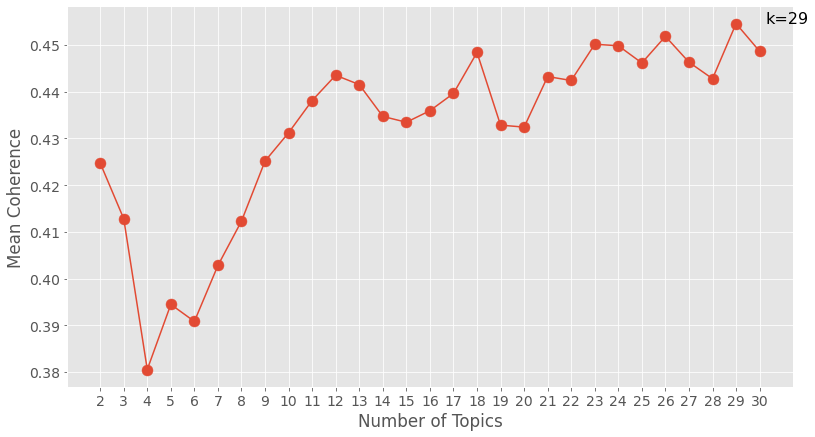

In [44]:
import matplotlib
%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

# pyLDAVis for LDA

In [45]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [46]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.062300 -0.161338       1        1  21.960213
9     -0.012078 -0.182861       2        1  15.812237
0      0.069096  0.033583       3        1  12.105275
2      0.199382 -0.032632       4        1  11.622448
8      0.165940  0.015562       5        1   9.741702
4      0.100572  0.072081       6        1   7.801436
7      0.066551  0.082062       7        1   6.304140
1     -0.310890 -0.111298       8        1   5.904242
5     -0.193689 -0.087277       9        1   5.034873
3     -0.147185  0.372118      10        1   3.713434, topic_info=            Term          Freq         Total Category  logprob  loglift
12         child  13314.000000  13314.000000  Default  30.0000  30.0000
64        school   9576.000000   9576.000000  Default  29.0000  29.0000
855      student   8470.000000   8470.000000  Default  28.0000  28.0000
446         said  17562.000000  17562.000000  Default  27.0000  27.0000
625       people  26641.000000  26641.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1840        news    959.281795   1581.915132  Topic10  -4.6656   2.7930
1155       story   1264.134274   3694.532712  Topic10  -4.3896   2.2207
1217        post    697.277533   1090.673236  Topic10  -4.9846   2.8458
508   television    702.486636   1205.262982  Topic10  -4.9771   2.7534
100      company    877.538167   3249.031552  Topic10  -4.7546   1.9842

[584 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
863       4  0.636017   ability
863       5  0.188403   ability
863       6  0.175126   ability
4054      6  0.998772  academic
512       1  0.997423  accepted
...     ...       ...       ...
336       7  0.059295      year
4938      9  0.998269    yellow
395       2  0.385396     young
395       4  0.518277     young
395       6  0.096196     young

[1015 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 1, 3, 9, 5, 8, 2, 6, 4])

# TSNE Visualization for LDA

In [47]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [48]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [49]:
# tSNE Dimension Reduction
import matplotlib.colors as mcolors
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8662 samples in 0.012s...
[t-SNE] Computed neighbors for 8662 samples in 0.889s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8662
[t-SNE] Computed conditional probabilities for sample 2000 / 8662
[t-SNE] Computed conditional probabilities for sample 3000 / 8662
[t-SNE] Computed conditional probabilities for sample 4000 / 8662
[t-SNE] Computed conditional probabilities for sample 5000 / 8662
[t-SNE] Computed conditional probabilities for sample 6000 / 8662
[t-SNE] Computed conditional probabilities for sample 7000 / 8662
[t-SNE] Computed conditional probabilities for sample 8000 / 8662
[t-SNE] Computed conditional probabilities for sample 8662 / 8662
[t-SNE] Mean sigma: 0.061974


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.324852
[t-SNE] KL divergence after 1000 iterations: 1.508186


Loading BokehJS ...

# pyLDAVis for NMF

In [50]:
import pyLDAvis.sklearn
nmf_vis_data = pyLDAvis.sklearn.prepare(nmf, tfidf, tfidf_vectorizer)
pyLDAvis.display(nmf_vis_data)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# TSNE visuallization for NMF

In [110]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


In [111]:
nmf_embedding.shape

(18728, 25)

In [112]:
arr.shape

(8662, 10)

In [113]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

In [114]:

tsne_embedding = pd.DataFrame(nmf_embedding).fillna(0).values
tsne_embedding = tsne_embedding[np.amax(tsne_embedding, axis=1) > 0.35]
topic_num = np.argmax(tsne_embedding, axis=1)
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99)
tsne_embedding = tsne.fit_transform(tsne_embedding)
# Dominant topic number in each doc
# tsne_embedding['hue'] = np.argmax(tsne_embedding,axis=1)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18343 samples in 0.001s...
[t-SNE] Computed neighbors for 18343 samples in 7.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18343
[t-SNE] Computed conditional probabilities for sample 2000 / 18343
[t-SNE] Computed conditional probabilities for sample 3000 / 18343
[t-SNE] Computed conditional probabilities for sample 4000 / 18343
[t-SNE] Computed conditional probabilities for sample 5000 / 18343
[t-SNE] Computed conditional probabilities for sample 6000 / 18343
[t-SNE] Computed conditional probabilities for sample 7000 / 18343
[t-SNE] Computed conditional probabilities for sample 8000 / 18343
[t-SNE] Computed conditional probabilities for sample 9000 / 18343
[t-SNE] Computed conditional probabilities for sample 10000 / 18343
[t-SNE] Computed conditional probabilities for sample 11000 / 18343
[t-SNE] Computed conditional probabilities for sample 12000 / 18343
[t-SNE] Computed conditional probabilities for sam

In [115]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 25
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_embedding[:,0], y=tsne_embedding[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

# WordCloud for each Topic (NMF)

Topic 0
said went asked told came looked house home year took little time thought room door knew wanted left girl felt night away hand walked later 



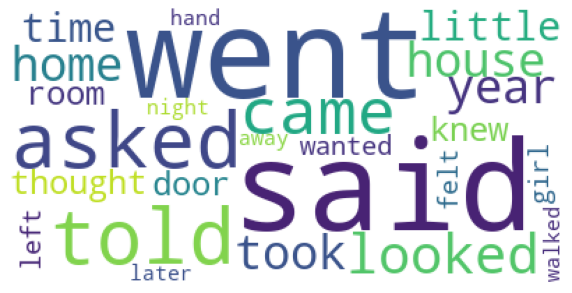

Topic 1
school teacher high class education student grade classroom homework pupil math middle girl teaching year summer parent learning activity primary state lesson work elementary subject 



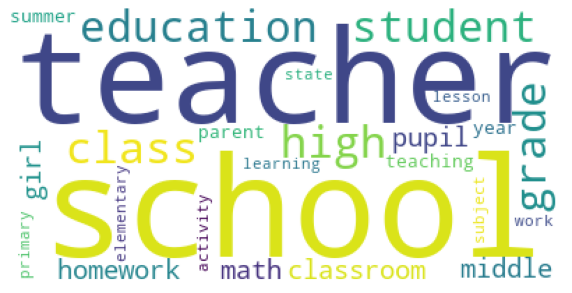

Topic 2
child parent family adult young home learn help education play teenager time baby teach television childhood activity need spend program development learning year educational playing 



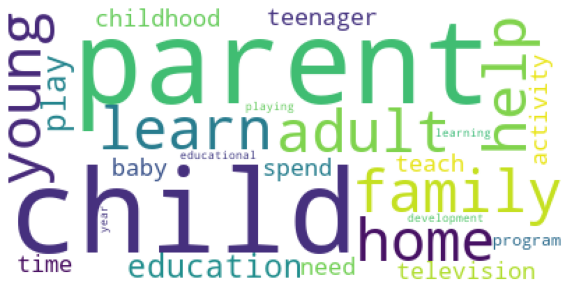

Topic 3
study percent researcher health said people disease research cancer university risk year likely scientist smoking effect according heart patient doctor report blood death level cause 



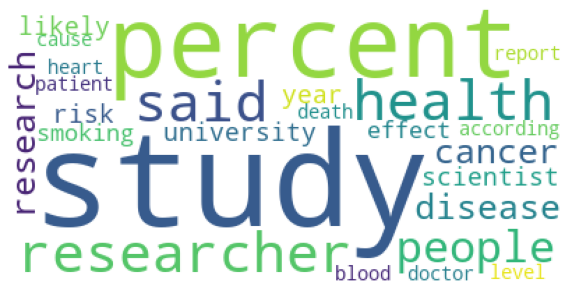

Topic 4
english language word speak learn learning speaker speaking foreign grammar american british dictionary spoken native culture understand french vocabulary country chinese mistake learner german listening 



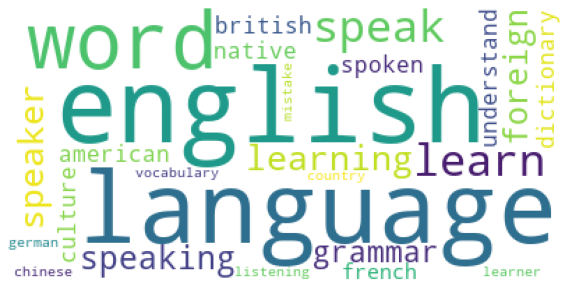

Topic 5
city world park museum country london hotel place people year travel area visit building tour state american trip home visitor ticket tourist york island road 



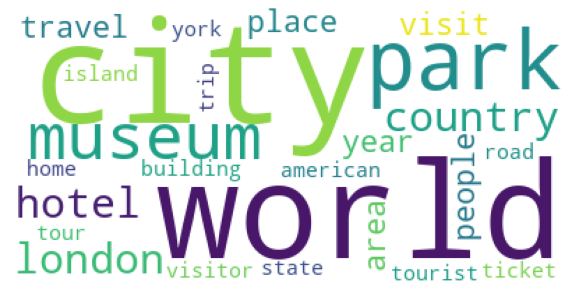

Topic 6
animal plant bird tree elephant human specie scientist wild forest wildlife bear park leaf habitat natural insect soil tiger land area fish nature live grow 



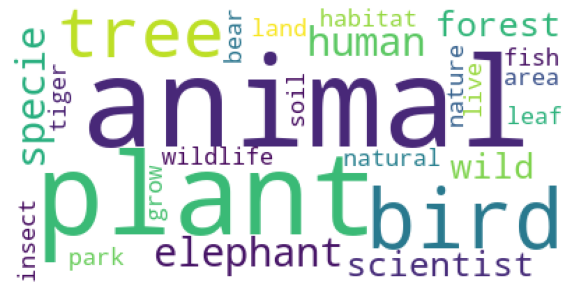

Topic 7
woman male female girl husband work marriage married likely young beauty paid wife usually american marry clothes fashion percent family career college attractive average difference 



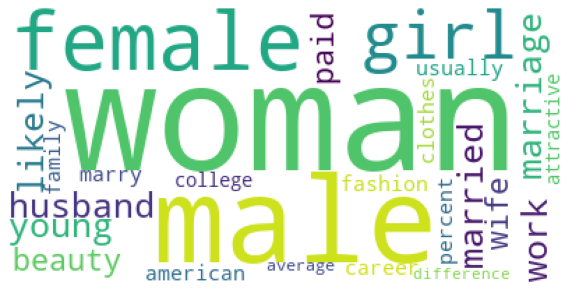

Topic 8
book reading read story library reader novel writing word page writer author write newspaper written poem published literature magazine text publisher paper character harry copy 



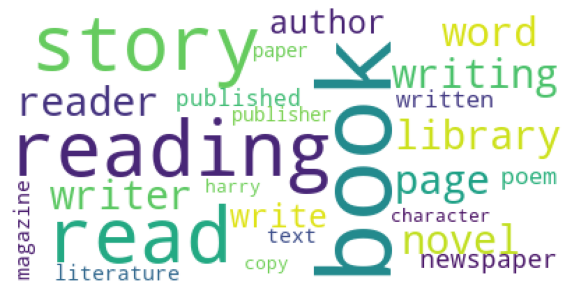

Topic 9
phone mobile cell text device technology message smart user using iphone driving cellphone texting messaging battery communication driver service telephone conversation video talking ring wireless 



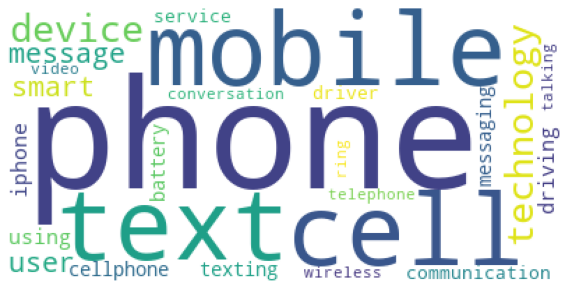

Topic 10
food eating meal vegetable meat restaurant fruit diet vitamin dinner healthy drink milk fish fast people product organic dish taste table plate calorie cooking cook 



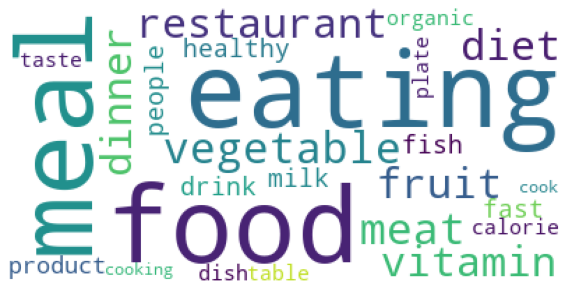

Topic 11
weight exercise body diet calorie healthy overweight lose eating muscle blood health pound heart physical obese obesity fitness breakfast walking loss activity gain walk habit 



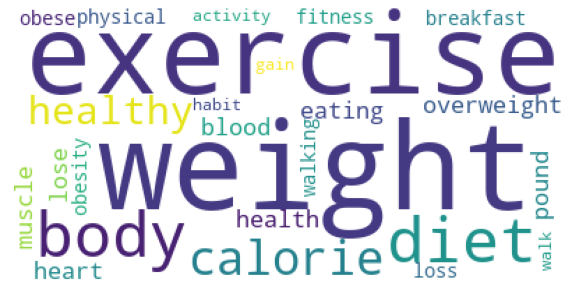

Topic 12
music song musical singer play listening concert jazz musician band rock festival played singing sound instrument listen classical dance popular album piano radio folk sing 



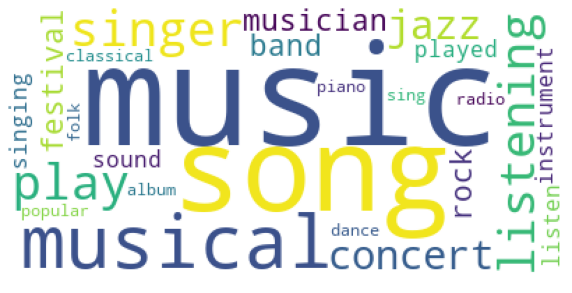

Topic 13
chinese china beijing said country culture yuan year shanghai government province percent japan literature million western zhang prize cultural wang foreign world american market economic 



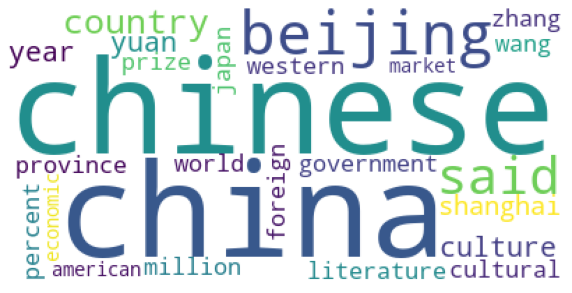

Topic 14
friend friendship make good relationship best talk family share feel need like social true facebook close party know time want friendly help happy person feeling 



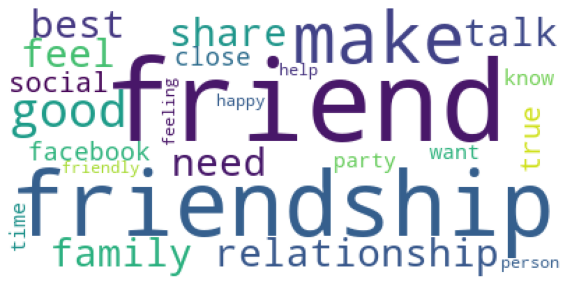

Topic 15
water fish bottled drinking drink river ocean lake bottle cold temperature plant waste boat clean surface glass supply energy pollution heat plastic rain land liter 



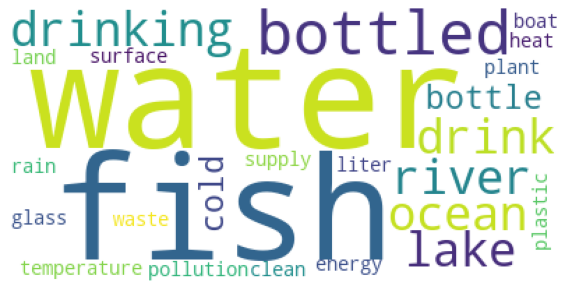

Topic 16
student college university education course class test graduate study exam degree year learning teacher program campus grade skill classroom science professor academic subject teaching help 



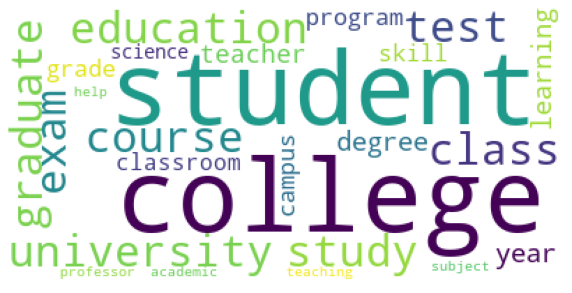

Topic 17
game sport player team play olympic football playing basketball olympics video ball athlete played coach match baseball soccer held league world year medal watch competition 



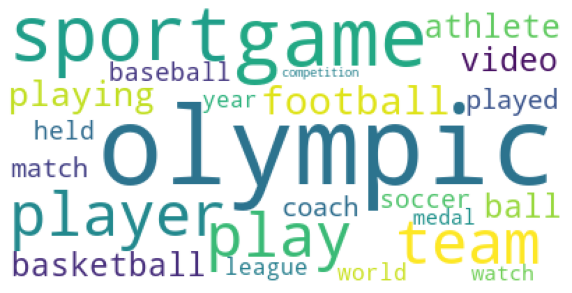

Topic 18
sleep night hour sleeping asleep body time morning light awake wake slept clock bedtime need getting minute late teen early pattern sleepy sleeper rest fall 



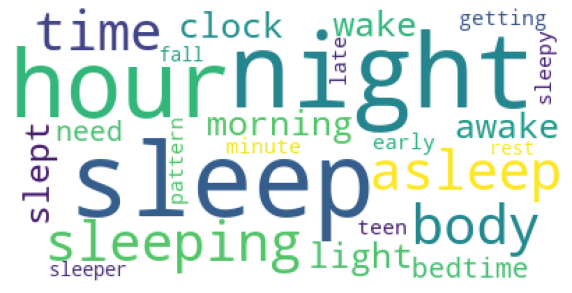

Topic 19
computer internet online information company technology user mail shopping website site product store service business newspaper network customer card software blog news medium sale google 



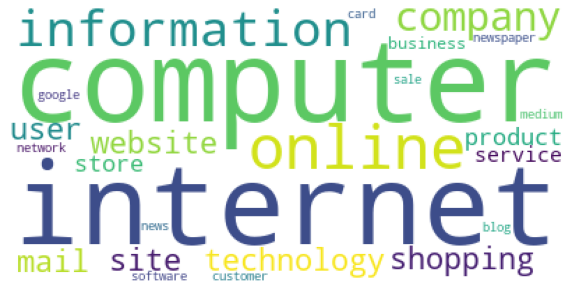

Topic 20
mother father baby daughter girl love family sister life born gift parent died honor care brother sunday jarvis year married birth hard loved home tell 



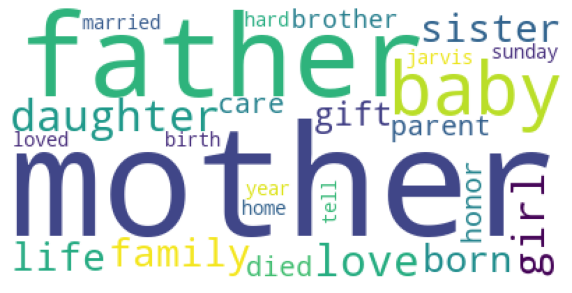

Topic 21
space earth planet moon astronaut scientist nasa station mission atmosphere solar satellite star human surface temperature robot light shuttle orbit spacecraft ocean flight gravity heat 



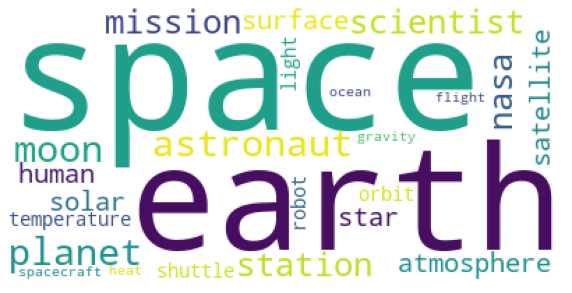

Topic 22
people life thing make time work think feel know good like want person need help important change better really problem mean different feeling look learn 



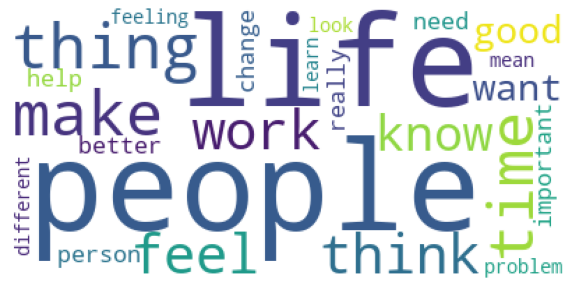

Topic 23
money bank dollar pocket saving card spend save credit cost price earn spending financial account paid company happiness allowance cash value coin rich debt clothes 



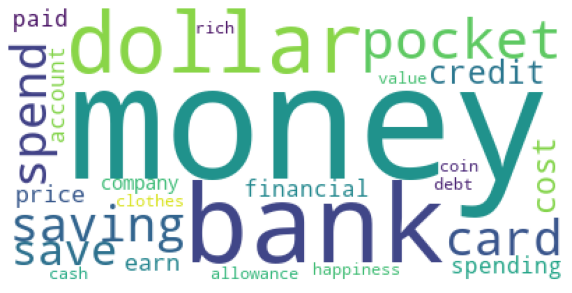

Topic 24
brain memory scientist cell study research researcher activity learning ability test human intelligence mind remember task better exercise university training language word nerve cognitive sound 



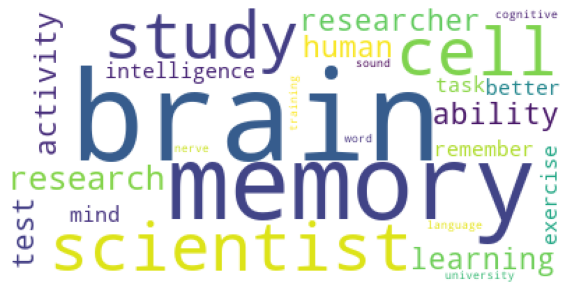

In [117]:
for topic in range(25):
    print('Topic', topic)
    word_list = resultslmf.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')
    all_articles = ' '.join(word_list[0:25])
    stopwords = STOPWORDS
    stopwords.add('will')
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(all_articles)
    rcParams['figure.figsize'] = 10, 20
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## According to NMF Topic Modeling:
## Topics are:
1. Home  
2. School  
3. Family  
4. Research  
5. Languages
6. Traveling  
7. Zoology  
8. Gender  
9. Reading  
10. Technology
11. Food  
12. Fitness  
13. Music  
14. China  
15. Friendship
16. Oceanology  
17. College  
18. Sports  
19. Sleeping  
20. Internet
21. Parents  
22. Space  
23. People Life  
24. Money  
25. Brain